# Conductance-Based Spiking Neural Network

Following derivatives are used for computing input estimate and voltage

$\frac{d\hat{x}}{dt} = -\frac{1}{\tau}\hat{x} + \displaystyle \sum^{N}_{k = 1} D_{k} s_{k}$

$\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - (V - E) \displaystyle\sum^{N}_{k - 1} (D_{i}^{T} D_{k}) s_{k}$

Initialize parameters

In [1]:
import numpy as np
import pylab as pl
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import random
import copy
import scipy.integrate as integrate
import sys
import scipy
import math

Following functions are used for plotting the results

In [2]:
def zero_to_nan(values):
    """Replace every 0 with 'nan' and return a copy."""
    
    return [float('nan') if x==0 else x for x in values]

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [3]:
# exponential filter
def exponential_filter(t, tau):
    return np.exp(-t/tau)

# initialize filter
def initialize_filter(x, tau):
    return [exponential_filter(i, tau) for i in x]

# compute firing rate
def firing_rate(spike_train, filt):
    return np.convolve(spike_train, filt)

Compute and plot firing rate per neuron

In [4]:
def plot_firing_rate():
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 9
    x = np.linspace(0, tau * 10, 1000)
    y = initialize_filter(x, tau)

    # initialize plots
    plots = N
    pl.subplots(plots, 1)
    pl.suptitle('Firing rate', fontsize=15)
    counter = 1

    # compute input estimate 
    for i in range(1, N+1):

        # compute firing rate
        spike_train = [1 if x==100 else x for x in o[i - 1, :]]
        firingrate = firing_rate(spike_train, y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0:iterations], color=color[i - 1][:]/255, label='N%i' %i)
        pl.ylim(0, 3.5)
        pl.legend()

### Spike count

Plot spike count per neuron

In [6]:
def spike_count():

    # count spikes
    count = o.sum(axis=1) * (1/100)

    # plot
    pl.bar(np.arange(1, N+1, 1), count, width=0.5, color='gray')
    pl.xlim(0, N + 1)
    pl.ylabel('Count')
    pl.xticks([])

### Voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\dot{\hat{V}} = -V + \Gamma c -\Gamma^{2} o$

2) Compute voltage estimate using a linear readout applied to the spike trains $V = D_{i}(x - \hat{x})$

In [8]:
def plot_voltage():
    
    return None

### Inpute estimate

Compute input estimate one of two ways:

1) Computed input estimate using the derivative $\dot{\hat{x}} = -\hat{x} + \Gamma o$

2) Compute input estimate using a linear readout applied to the spike trains $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$

In [7]:
def plot_estimate():
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 9
    val = np.linspace(0, tau * 10, 1000)
    y = initialize_filter(val, tau)

    # compute input estimate (by method 2)
    x_est2 = np.zeros(iterations)
    for t in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est2[t] = x_est2[t] + D[0][i] * firingrate[t] 

    # plot input estimates
    pl.subplots(1, 2, figsize=(14, 2))
    #pl.suptitle('Input estimate $\hat{x}$', fontsize=15)
    pl.subplot(1, 2, 1)
    pl.title('Online $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$', fontsize='20')
    pl.plot(x_est, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.xlabel('time')
    pl.legend()
    pl.subplot(1, 2, 2)
    pl.title('Offline $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$',  fontsize='20')
    pl.plot(x_est2, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    pl.xlabel('time')
    pl.legend()

## Simulation SNN

### Time varying signal

Create time varying signal

In [9]:
def time_varying_signal(c_upp=3):

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 4 * step:iterations] = 1

    x = gaussian_filter1d(x_t, sigma=20) # smooth signal

    dxdt = np.diff(x)/dt
    c = x[:-1] + dxdt
    
    return (x, c)

### Run simulation

In [111]:
def run(E, noise_signal=0, split=0):
    
    neurons = np.arange(0, N, 1)
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt
        
        if split == 0:
            # compute update value
            update_weighted = np.dot(D.T * D + np.identity(N) * beta , o[:, t - 1])
            driving_force = voltage[:, t - 1] - E
            update = np.multiply(update_weighted, driving_force)

            # update voltage
            dVdt = -voltage[:, t - 1] + D[0] * c[t - 1] - update
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt
        else:
            # compute update value
            connection = D.T * D
            np.fill_diagonal(connection, 0)
            update_weighted = np.dot(connection , o[:, t - 1])
            driving_force = voltage[:, t - 1] - E
            update = np.multiply(update_weighted, driving_force)

            # update voltage
            self = [x**2 for x in D]
            dVdt = -voltage[:, t - 1] + D[0] * c[t - 1] - np.dot((np.identity(N) * self) + np.identity(N) * beta, o[:, t - 1]) - update
            voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        above_threshold = neurons[np.where(voltage[:, t] > T)]

        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

### Plot results

In [11]:
def plot(E, color, plot_voltage=1):
    plots = N + 2
    pl.subplots(plots, 1, figsize=(14, 12)) 
    pl.subplots_adjust(hspace=0.7)

    # enable LaTeX
    pl.rc('text', usetex=True)

    pl.subplot(plots, 1, 1)
    pl.title('Input and input estimate', fontsize=25)
    pl.plot(x, label=r'$x$', color='black')
    pl.plot(x_est, label=r'$\hat{x}$', color='gray')
    pl.xlim(0, iterations)
    pl.legend()
    
    pl.subplot(plots, 1, 2)
    pl.title('Spikes', fontsize=25)
    for i in range(1, N + 1):
        
        values = zero_to_nan(o[i - 1, :] * i)
                
        pl.scatter(np.arange(0, iterations), values, color=color[i - 1][:]/255, label='Neuron %i' %i)
        pl.yticks([])
        pl.xticks([])
        pl.title('Spike train', fontsize=25)
        pl.ylim(0, 100 * N + 100)
        pl.xlim(0, iterations)
        
    # Put a legend to the right of the current axis
    pl.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    counter = 3

    for i in range(1, N + 1):
        neuron = i + 1

        pl.subplot(plots, 1, counter)
        pl.title('Voltage N%i' %i, fontsize=25)
        pl.plot(voltage[i - 1], color=color[i - 1][:]/255, label='N%i'%i)
        pl.plot(np.arange(0, iterations), np.ones(iterations) * T[i - 1], color='gray', label='threshold')
        pl.xlim(0, iterations)
        pl.ylabel('Voltage')
        pl.ylim(voltage.min() - 0.2 * (voltage.max() - voltage.min()), voltage.max() + 0.2 * (voltage.max() - voltage.min()))
        pl.legend()

        counter = counter + 1

## Initialize parameters

Homogeneous network

In [12]:
def initialize_params_homogeneous(N, dt, iterations, gamma, beta):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    D = np.ones((1, N)) * gamma

    # threshold
    T = [(weight ** 2)/2 + beta/2 for weight in D[0]]

    return (t, x_est, o, voltage, D, T) 

Heterogeneous network

In [13]:
def initialize_params_heterogeneous(N, dt, iterations, beta):

    # timesteps
    t = np.arange(0, iterations) * dt

    # input estimate
    x_est = np.zeros(iterations)

    # spike trains
    o = np.zeros((N, iterations))

    # voltages
    voltage = np.zeros((N, iterations))

    # ''output kernel''
    D = np.random.normal(1/N, 0.5, size=(1,N))

    # threshold
    T = [(weight ** 2)/2 + beta/2 for weight in D[0]]

    return (t, x_est, o, voltage, D, T) 

## $\textit{N}$-neurons (homogeneous network)

Initialize parameters

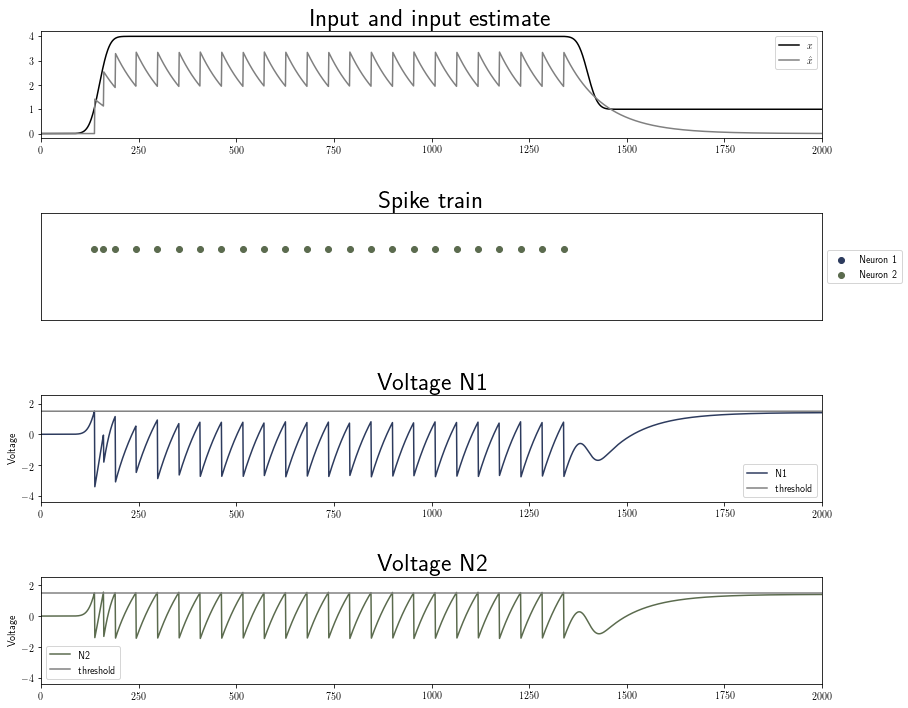

In [112]:
# Run simulation and plot results for given parameters
N = 2                                                    # number of neurons  
c_upp = 4                                                # value input signal
dt = 0.01                                                # step size
iterations = 2000                                        # number of time steps
gamma = math.sqrt(2)                                     # weights
beta = 1.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

# initliaze reversal potentials
E = np.ones(N) * -1

# run simulation
t, x_est, o, voltage, D, T = initialize_params_homogeneous(N, dt, iterations, gamma, beta)
x,c = time_varying_signal(c_upp)
run(E, noise_signal=0, split=1)
plot(E, color, plot_voltage=1)

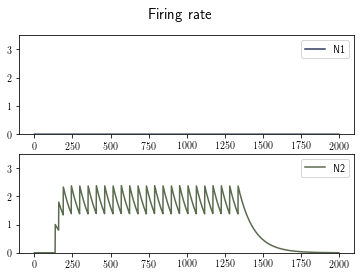

In [113]:
plot_firing_rate()

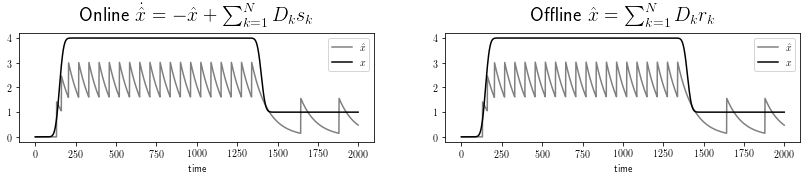

In [98]:
plot_estimate()

In [99]:
plot_voltage()

## $\textit{N}$-neurons (heterogeneous network)

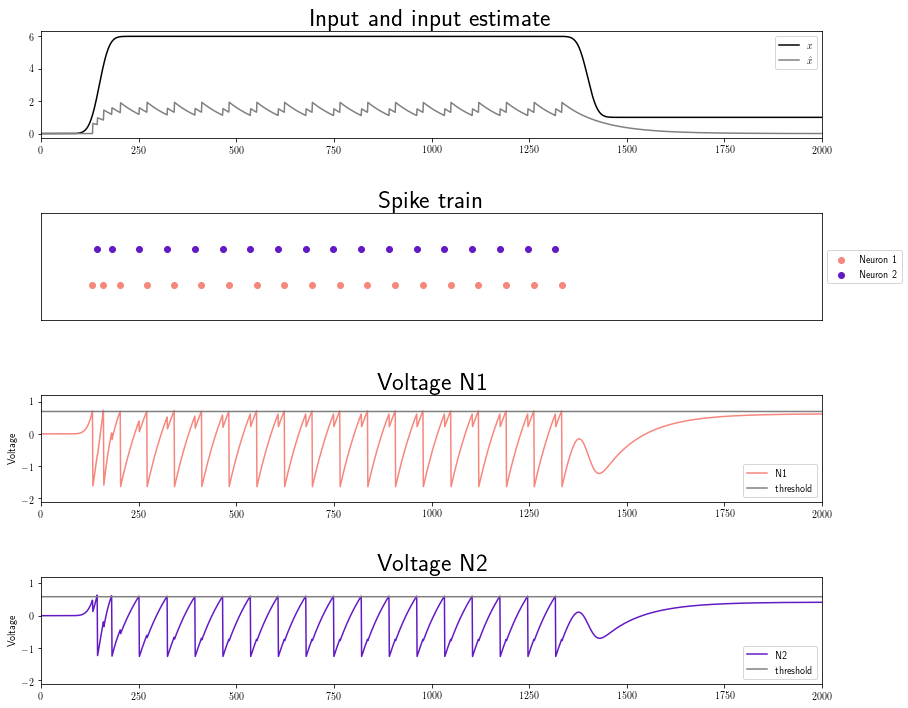

In [115]:
# Run simulation and plot results for given parameters
N = 2                                                    # number of neurons  
c_upp = 6                                                # value input signal
dt = 0.01                                                # step size
iterations = 2000                                        # number of time steps
beta = 1.0                                               # cost
color = np.random.randint(0, 255, size=(N, 3))           # return set of colors

# initliaze reversal potentials
E = np.ones(N) * -1

# run simulation
t, x_est, o, voltage, D, T = initialize_params_heterogeneous(N, dt, iterations, beta)
x,c = time_varying_signal(c_upp)
run(E, noise_signal=0, split=0)
plot(E, color, plot_voltage=1)

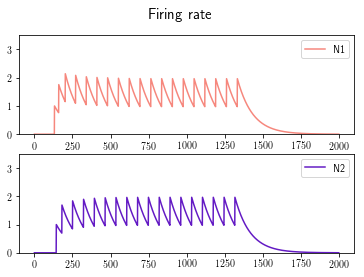

In [116]:
plot_firing_rate()

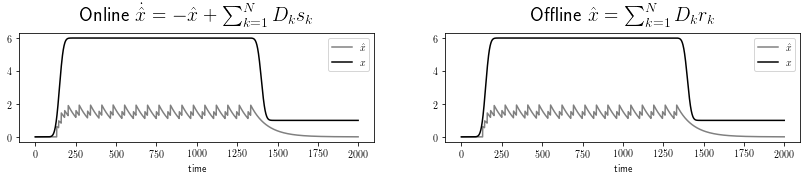

In [117]:
plot_estimate()

In [509]:
plot_voltage()